In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import gc
import re
import csv
import os
import gc
import torch
# set to "cuda:1" for running in parallel on both GPUs
device = torch.device("cuda:0")
torch.cuda.set_device(device)
torch.set_default_device(device)
import networkx as nx
import Stemmer
import pandas as pd
from tqdm import tqdm
from langchain_community.graphs.networkx_graph import get_entities
from utils.preprocessing import preprocess_text
from utils.graph import KGraphPreproc
from utils.graph.chain import GraphChain
from utils.llm.mistral import MistralLLM
from utils.prompt import GRAPH_QA_PROMPT, ENTITY_PROMPT
from utils.file import export_results_to_file

### Load and generate a subset

In [104]:
cwq = pd.read_json("/datasets/CWQ/ComplexWebQuestions_dev.json")
print(len(cwq))
cwq.head(1)

3519


,ID,answers,composition_answer,compositionality_type,created,machine_question,question,sparql,webqsp_ID,webqsp_question
0,WebQTrn-1430_ac053cda0a7424c48e4809c71171fbed,"[{'aliases': [], 'answer': 'Muhammad Zia-ul-Ha...",pakistan,composition,2018-02-12T22:17:21,who was the president of the country that cont...,Who was the president in 1980 of the country t...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTrn-1430,who was the president of pakistan in 1980


### Extract answer ids

In [38]:
def convert_entity(entity, reverse=False):
    """
    converts: m.07j6w into /m/07j6w
    reverse does the opposite
    """
    if reverse:
        return entity[1:].replace("/", ".")
    return "/" + entity.replace(".", "/")

In [39]:
def get_answer_ids(answers):
    return list(map(lambda x: convert_entity(x["answer_id"]), answers))

In [40]:
def ids_in_graph(id_list):
    return any([id_ in fbkb_graph._graph for id_ in id_list])

### Counts of questions with at least one answer ids in graph

In [106]:
cwq["answer_ids"] = cwq["answers"].apply(lambda x: get_answer_ids(x))

In [107]:
cwq_answer_present = cwq[cwq["answer_ids"].apply(ids_in_graph)]
print(len(cwq_answer_present))
cwq_answer_present.groupby("compositionality_type").count()

2227


,ID,answers,composition_answer,created,machine_question,question,sparql,webqsp_ID,webqsp_question,answer_ids
compositionality_type,,,,,,,,,,
comparative,124,124,124,124,124,124,124,124,124,124
composition,926,926,926,926,926,926,926,926,926,926
conjunction,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070
superlative,107,107,107,107,107,107,107,107,107,107


### Load the graph and entity extraction chain

In [87]:
####### load the graph
fbkb_graph = KGraphPreproc.get_fbkb_graph()

In [ ]:
mistral = MistralLLM()

In [ ]:
chain = GraphChain.from_llm(
    llm=mistral,
    graph=fbkb_graph,
    qa_prompt=GRAPH_QA_PROMPT,
    entity_prompt=ENTITY_PROMPT,
    verbose=False,
)

### Infer topic entities from the questions

In [11]:
def extract_entity(row):
    entity_string = chain.entity_extraction_chain.run(row.question)
    entities = get_entities(entity_string)
    pbar.update(1)
    return entities

In [ ]:
pbar = tqdm(total=len(cwq_answer_present))
cwq_answer_present["topic_entities"] = cwq_answer_present.apply(extract_entity, axis=1)

100%|██████████| 2227/2227 [22:37<00:00,  1.87it/s] /tmp/ipykernel_23916/692259211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cwq_answer_present["topic_entities"] = cwq_answer_present.apply(extract_entity, axis=1)


### Save entities

In [102]:
cwq_answer_present[["ID", "topic_entities"]].to_csv("/datasets/CWQ/topic_entities.csv")

### Load entities

In [147]:
topic_ents = pd.read_csv("/datasets/CWQ/topic_entities.csv")
# ["topic_entities"].values
# add "topic_entities" fields based on matching ID
# into a single column topic_entities
cwq_answer_present = cwq_answer_present.merge(topic_ents, on="ID")
# topic_ents

In [72]:
def entities_to_ids(entities):
    mid_list = []
    for entity in entities:
        proc_entity = preprocess_text(entity)
        mid = fbkb_graph.preprocessed_nodes.get(proc_entity, None)
        if mid:
            mid_list.append(mid)
    return mid_list

In [149]:
cwq_answer_present["topic_ids"] = cwq_answer_present["topic_entities"].apply(entities_to_ids)

In [150]:
cwq_both_present = cwq_answer_present[cwq_answer_present["topic_ids"].apply(lambda x: len(x) > 0)]

### Check path present

In [75]:
def has_graph_path(row):
    for start in row.topic_ids:
        for target in row.answer_ids:
            try:
                if nx.has_path(fbkb_graph._graph, start, target):
                    return True
            except nx.NodeNotFound:
                continue
    return False

In [151]:
cwq_paths = cwq_both_present[cwq_both_present.apply(has_graph_path, axis=1)]
print(len(cwq_paths))

2215


## count unique entities

In [154]:
cwq_paths.head(1)

,ID,answers,composition_answer,compositionality_type,created,machine_question,question,sparql,webqsp_ID,webqsp_question,answer_ids,Unnamed: 0_x,topic_entities_x,topic_ids,Unnamed: 0_y,topic_entities_y,Unnamed: 0,topic_entities
0,WebQTest-823_ed31f9dd431831dbd32a06b958c7c97c,"[{'aliases': ['Brazilian ', 'República Federat...",,conjunction,2018-02-13T04:12:26,what does bolivia border and is the country th...,What country borders Bolivia and contains GoiÃ¡s?,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTest-823,what does bolivia border,[/m/015fr],2,['Brazil'],"[/m/0g84t93, /m/0g84t93, /m/0k20s, /m/0g84t93,...",2,['Brazil'],2,['Brazil']


In [159]:
cwq_paths.answer_ids

0                   [/m/015fr]
1        [/m/01xssh, /m/03v6t]
2                   [/m/0cc56]
3                   [/m/0pspl]
4                   [/m/06yxd]
                 ...          
2222               [/m/02rqxc]
2223                [/m/0flbm]
2224                [/m/0345_]
2225    [/m/02hwl5z, /m/0swlx]
2226                [/m/03j6c]
Name: answer_ids, Length: 2215, dtype: object

In [160]:
cwq_paths.answer_ids.apply(
    lambda a: [fbkb_graph.mid2name.get(x, None) for x in a]
)

0                                [Brazil]
1           [None, Iowa_State_University]
2                             [Manhattan]
3                 [Georgetown_University]
4                        [South_Carolina]
                      ...                
2222    [Portugal_national_football_team]
2223                     [Douglas_County]
2224                          [Guatemala]
2225              [None, Pashto_language]
2226                           [Hinduism]
Name: answer_ids, Length: 2215, dtype: object

In [161]:
# merge sublists into a single set
total_unique_entities = set()
cwq_paths.topic_entities.apply(ast.literal_eval).apply(lambda x: total_unique_entities.update(x))
cwq_paths.answer_ids.apply(
    lambda a: [fbkb_graph.mid2name.get(x, None) for x in a]
).apply(lambda x: total_unique_entities.update(x))
print(len(total_unique_entities))
# = cwq_paths["topic_ids"].apply(lambda x: [item for sublist in x for item in sublist])

3353


In [136]:
present_unique_entities = set()

In [139]:
cwq_paths.head(1)

,ID,answers,composition_answer,compositionality_type,created,machine_question,question,sparql,webqsp_ID,webqsp_question,answer_ids,Unnamed: 0,topic_entities,topic_ids
0,WebQTest-823_ed31f9dd431831dbd32a06b958c7c97c,"[{'aliases': ['Brazilian ', 'República Federat...",,conjunction,2018-02-13T04:12:26,what does bolivia border and is the country th...,What country borders Bolivia and contains GoiÃ¡s?,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTest-823,what does bolivia border,[/m/015fr],2,['Brazil'],"[/m/0g84t93, /m/0g84t93, /m/0k20s, /m/0g84t93,..."


In [141]:
import ast

In [146]:
cwq_paths["topic_entities"] = cwq_paths["topic_entities"].apply(ast.literal_eval)


ValueError: malformed node or string: ['Brazil']

In [137]:
present_unique_entities.update(cwq_paths["topic_entities"].explode().unique())
present_unique_entities.update(cwq_paths["answer_ids"].explode().apply(
    lambda x: fbkb_graph.mid2name.get(x, None)
).unique())

print(len(unique_entities))


0


In [78]:
cwq_paths.groupby("compositionality_type").count()

,ID,answers,composition_answer,created,machine_question,question,sparql,webqsp_ID,webqsp_question,answer_ids,Unnamed: 0,topic_entities,topic_ids
compositionality_type,,,,,,,,,,,,,
comparative,120,120,120,120,120,120,120,120,120,120,120,120,120
composition,818,818,818,818,818,818,818,818,818,818,818,818,818
conjunction,952,952,952,952,952,952,952,952,952,952,952,952,952
superlative,100,100,100,100,100,100,100,100,100,100,100,100,100


### Look at number of hops

In [27]:
def get_path_len(row):
    for start in row.topic_ids:
        for target in row.answer_ids:
            try:
                if nx.has_path(fbkb_graph._graph, start, target):
                    return nx.shortest_path_length(fbkb_graph._graph, start, target)
            except nx.NodeNotFound:
                continue
    return -1

In [29]:
cwq_paths["hops"] = cwq_paths.apply(get_path_len, axis=1)
cwq_paths

/tmp/ipykernel_3173/1313171908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cwq_paths["hops"] = cwq_paths.apply(get_path_len, axis=1)


,ID,answers,composition_answer,compositionality_type,created,machine_question,question,sparql,webqsp_ID,webqsp_question,answer_ids,topic_entities,topic_ids,hops
2,WebQTest-823_ed31f9dd431831dbd32a06b958c7c97c,"[{'aliases': ['Brazilian ', 'República Federat...",,conjunction,2018-02-13T04:12:26,what does bolivia border and is the country th...,What country borders Bolivia and contains GoiÃ¡s?,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTest-823,what does bolivia border,[/m/015fr],['Brazil'],"[/m/0g84t93, /m/0g84t93, /m/0k20s, /m/0g84t93,...",5
10,WebQTest-1081_6118bd42202be020c123831a76c283c6,"[{'aliases': ['Simpson College, main campus', ...",george washington carver,composition,2018-02-13T04:38:25,where did the person education institution is ...,What college did the President who attended Mi...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTest-1081,where did george washington carver go to collage,"[/m/01xssh, /m/03v6t]","['Minneapolis High School', 'President']","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...",5
12,WebQTrn-2873_143c89d70679c3e5257c93d8e2bc4c67,"[{'aliases': ['New York County'], 'answer': 'M...",,conjunction,2018-02-13T00:49:15,where does hector camacho live and the locatio...,"Where does Hector Camacho live, where the loca...",PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTrn-2873,where does hector camacho live,[/m/0cc56],"['Hector Camacho', 'UTC-05:00 time zone']","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...",5
13,WebQTest-1508_872253e47dd6ddaa213ff31eeda8783b,"[{'aliases': ['Georgetown', 'Georgetown Univer...",,conjunction,2018-02-13T05:30:06,when did bill clinton go to college and the lo...,What college did Bill Clinton attend that is i...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTest-1508,when did bill clinton go to college,[/m/0pspl],"['Bill Clinton', 'College', 'Eastern Time Zone']","[/m/0g84t93, /m/0g84t93, /m/0g84t93, /m/0g84t9...",5
14,WebQTrn-2674_831fb3325644a924d433e2b267f6d238,"[{'aliases': ['SC', 'Palmetto State'], 'answer...",,conjunction,2018-02-13T00:25:17,where is usc from and is the us state that has...,Which state includes a university that sometim...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTrn-2674,where is usc from,[/m/06yxd],"['USC', 'university', 'state', 'Columbia', 'ci...","[/m/0g84t93, /m/0g84t93, /m/0g84t93, /m/0g84t9...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,WebQTrn-1977_b6077507bbaab84d25fcd56dde6347d7,"[{'aliases': ['Portugal Mens Football Team', '...",,superlative,2017-10-26T02:02:02,who does cristiano ronaldo play for and is the...,Which of the sports teams for whom Cristiano R...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTrn-1977,who does cristiano ronaldo play for,[/m/02rqxc],"['Cristiano Ronaldo', 'sports teams', 'founded']","[/m/0g84t93, /m/0g84t93, /m/0g84t93, /m/0g84t9...",6
3513,WebQTrn-1941_f7bece72409e67de63a4c67a8f0bff15,"[{'aliases': [], 'answer': 'Douglas County', '...",,conjunction,2017-10-26T01:56:45,where is downtown littleton and has industrial...,What county is home to downtown Littleton and ...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTrn-1941,where is downtown littleton,[/m/0flbm],"['Littleton', 'county', 'industrial CO2 emissi...","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...",5
3514,WebQTrn-2150_07cb920cde31205a4fd9196dfc55ac28,"[{'aliases': ['Guatemala.'], 'answer': 'Guatem...",,conjunction,2017-10-26T02:25:12,what 3 countries does mexico border and the IS...,Which of the 3 countries bordering Mexico has ...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTrn-2150,what 3 countries does mexico border,[/m/0345_],['United States'],"[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...",6
3515,WebQTrn-233_e803a6f9f263f7c8e6cfccb60becf497,"[{'aliases': ['Madaglashti', 'Badakhshi', 'Far...",afghanistan,composition,2017-10-25T21:38:01,what language people speak in the governmental...,What language is spoken in the politician Moha...,PREFIX 

<Axes: ylabel='Frequency'>

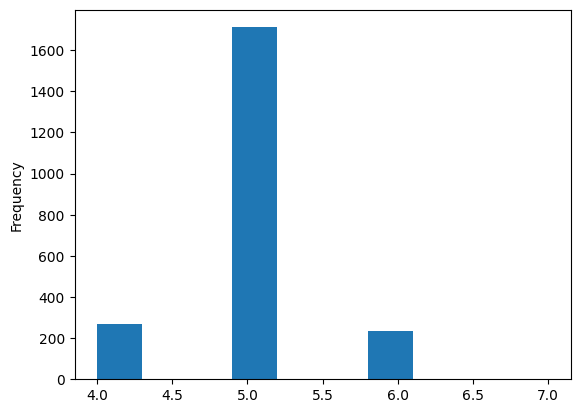

In [31]:
cwq_paths["hops"].plot.hist()

### Sample

In [35]:
sample_size = {
    "comparative": 100,
    "composition": 400,
    "conjunction": 400,
    "superlative": 100,
}
cwq_subset = cwq_paths.groupby("compositionality_type", group_keys=False).apply(lambda x: x.sample(n=sample_size[x.name], random_state=42))
cwq_subset.head(2)

/tmp/ipykernel_3173/446404923.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cwq_subset = cwq_paths.groupby("compositionality_type", group_keys=False).apply(lambda x: x.sample(n=sample_size[x.name], random_state=42))


,ID,answers,composition_answer,compositionality_type,created,machine_question,question,sparql,webqsp_ID,webqsp_question,answer_ids,topic_entities,topic_ids,hops
894,WebQTest-1311_e920e31a99d6b7dfbeef110668d3103d,"[{'aliases': ['W. Morris'], 'answer': 'William...",,comparative,2017-10-26T10:08:36,what was antoni gaudi inspired by and the pers...,What inspiration of Antoni Gaudi died later th...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTest-1311,what was antoni gaudi inspired by,[/m/08304],"['Antoni Gaudi', 'death date (not explicitly m...","[/m/0g84t93, /m/0g84t93, /m/0g84t93, /m/0g84t9...",5
1329,WebQTest-1382_b9b879060be6df6cb7cd937a7996f9d9,"[{'aliases': ['Brazilian ', 'República Federat...",,comparative,2017-10-26T10:25:29,what other countries border argentina and numb...,What country borders Argentina and has an army...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTest-1382,what other countries border argentina,[/m/015fr],"['Chile', 'Brazil']","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...",5


<Axes: ylabel='Frequency'>

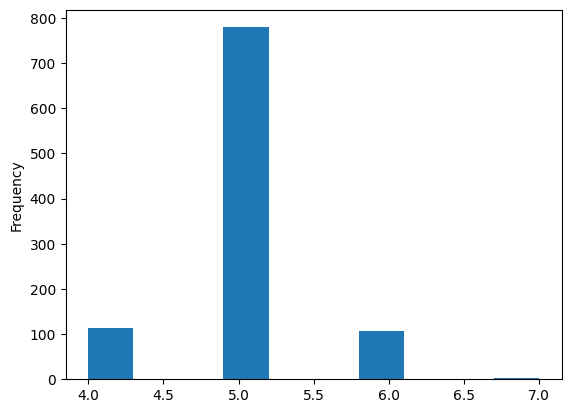

In [34]:
cwq_subset["hops"].plot.hist()

In [205]:
def extract_answers(answer_list):
    return list(map(lambda x: x["answer"], answer_list))

In [209]:
cwq_subset["answer_list"] = cwq_subset["answers"].apply(extract_answers)
cwq_subset.head(1)

,ID,answers,composition_answer,compositionality_type,created,machine_question,question,sparql,webqsp_ID,webqsp_question,topic_entities,topic_ids,answer_ids,answer_list
894,WebQTest-1311_e920e31a99d6b7dfbeef110668d3103d,"[{'aliases': ['W. Morris'], 'answer': 'William...",,comparative,2017-10-26T10:08:36,what was antoni gaudi inspired by and the pers...,What inspiration of Antoni Gaudi died later th...,PREFIX ns: <http://rdf.freebase.com/ns/>\nSELE...,WebQTest-1311,what was antoni gaudi inspired by,"['Antoni Gaudi', 'death date (not explicitly m...","[/m/0g84t93, /m/0g84t93, /m/0g84t93, /m/0g84t9...",[/m/08304],[William Morris]


In [210]:
cwq_subset[["ID", "compositionality_type", "question", "answers", "topic_ids", "answer_ids"]].to_csv("/datasets/CWQ/cwq-1000.csv")